# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc
from rapids_singlecell.cunnData import cunnData

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 1.99 s, sys: 195 ms, total: 2.18 s
Wall time: 2.18 s


In [5]:
%%time
cudata = rsc.cunnData.cunnData(adata=adata)

CPU times: user 1.17 s, sys: 728 ms, total: 1.9 s
Wall time: 1.9 s


In [6]:
adata.shape

(93575, 33694)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(93575, 33694)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

114212920

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 4.106814861297607


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 5.9 ms, sys: 742 µs, total: 6.64 ms
Wall time: 6.53 ms


In [12]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 7.34 ms, sys: 0 ns, total: 7.34 ms
Wall time: 7.25 ms


In [13]:
%%time
rsc.pp.calculate_qc_metrics(cudata,qc_vars=["MT","RIBO"])

CPU times: user 81.3 ms, sys: 7.87 ms, total: 89.2 ms
Wall time: 88.9 ms


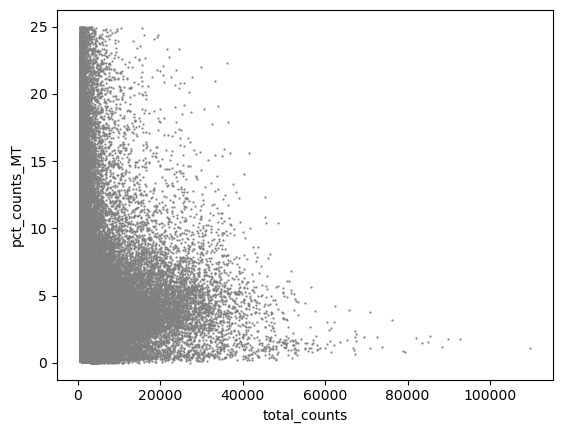

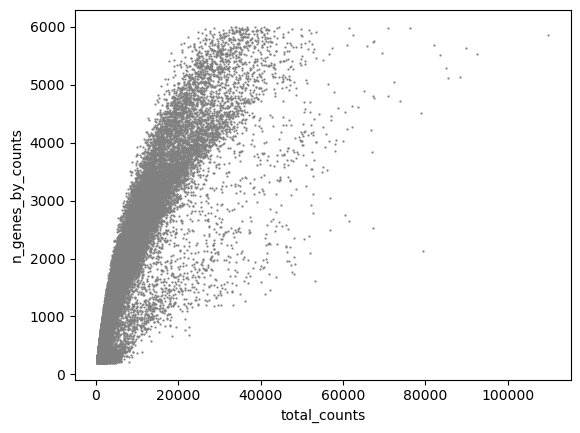

In [14]:
rsc.pl.scatter(cudata,"total_counts","pct_counts_MT")
rsc.pl.scatter(cudata,"total_counts","n_genes_by_counts")

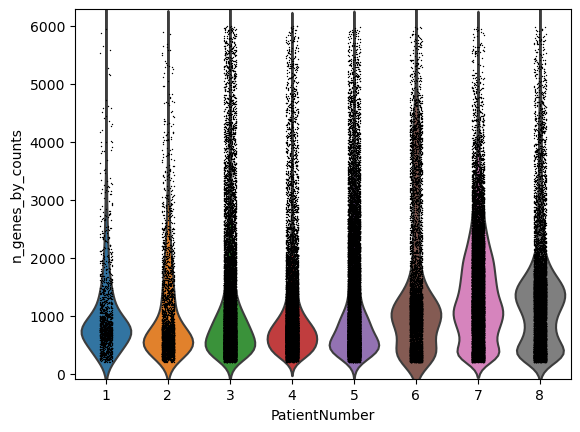

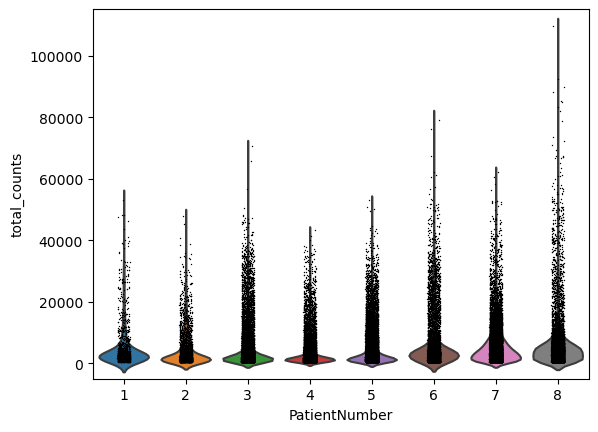

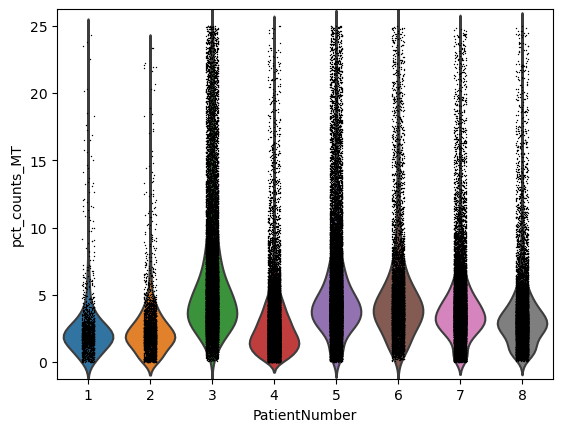

In [15]:
rsc.pl.violin(cudata,key="n_genes_by_counts",groupby="PatientNumber")
rsc.pl.violin(cudata,key="total_counts",groupby="PatientNumber")
rsc.pl.violin(cudata,key="pct_counts_MT",groupby="PatientNumber")

We store the raw expression counts in the `.layer["counts"]`

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [16]:
%%time
cudata = cudata[cudata.obs["n_genes_by_counts"] < 5000]
cudata.shape

CPU times: user 85.1 ms, sys: 49.3 ms, total: 134 ms
Wall time: 134 ms


(92666, 33694)

In [17]:
%%time
cudata = cudata[cudata.obs["pct_counts_MT"] < 20]
cudata.shape

CPU times: user 11.6 ms, sys: 11.4 ms, total: 23 ms
Wall time: 22.4 ms


(91180, 33694)

n_samplesWe also filter out genes that are expressed in less than 3 cells.

In [18]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 65.8 ms, sys: 28.7 ms, total: 94.5 ms
Wall time: 93.9 ms


In [19]:
cudata.layers["counts"] = cudata.X.copy()

In [20]:
cudata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [21]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 254 µs, sys: 358 µs, total: 612 µs
Wall time: 412 µs


Next, we log transform the count matrix.

In [22]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 6.24 ms, sys: 4.68 ms, total: 10.9 ms
Wall time: 10.6 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [23]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="seurat_v3",batch_key= "PatientNumber",layer = "counts")

CPU times: user 956 ms, sys: 1.89 s, total: 2.84 s
Wall time: 451 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [24]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 197 ms, sys: 66.3 ms, total: 264 ms
Wall time: 263 ms


Now we restrict our cunndata object to the highly variable genes.

In [25]:
%%time
cudata = cudata[:,cudata.var["highly_variable"]==True]

CPU times: user 81.3 ms, sys: 55.4 ms, total: 137 ms
Wall time: 136 ms


In [26]:
cudata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [27]:
%%time
rsc.pp.regress_out(cudata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 921 ms, sys: 842 ms, total: 1.76 s
Wall time: 1.76 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [28]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 44.4 ms, sys: 8.2 ms, total: 52.6 ms
Wall time: 52 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [29]:
%%time
rsc.pp.pca(cudata, n_comps = 100)

CPU times: user 704 ms, sys: 66 ms, total: 770 ms
Wall time: 769 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

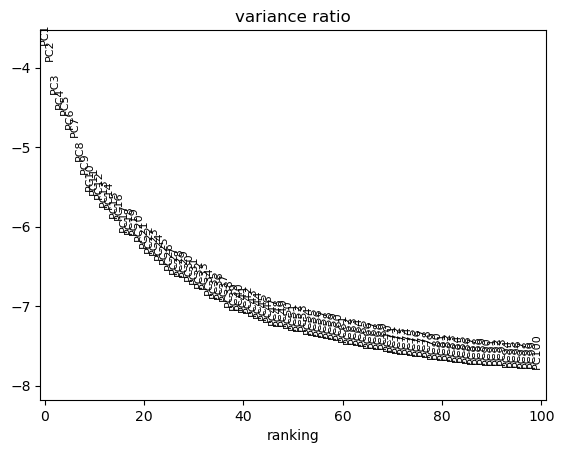

In [30]:
sc.pl.pca_variance_ratio(cudata, log=True,n_pcs=100)

Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [31]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 192 ms, sys: 99.3 ms, total: 291 ms
Wall time: 291 ms


In [32]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 6.126809120178223


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [33]:
%%time
rsc.tl.harmony_integrate(adata,key="PatientNumber")

2023-05-09 20:45:49,170 - harmonypy_gpu - INFO - Iteration 1 of 10
2023-05-09 20:45:52,004 - harmonypy_gpu - INFO - Iteration 2 of 10
2023-05-09 20:45:54,812 - harmonypy_gpu - INFO - Iteration 3 of 10
2023-05-09 20:45:57,609 - harmonypy_gpu - INFO - Iteration 4 of 10
2023-05-09 20:46:00,418 - harmonypy_gpu - INFO - Iteration 5 of 10
2023-05-09 20:46:03,233 - harmonypy_gpu - INFO - Iteration 6 of 10
2023-05-09 20:46:05,817 - harmonypy_gpu - INFO - Iteration 7 of 10
2023-05-09 20:46:07,552 - harmonypy_gpu - INFO - Iteration 8 of 10
2023-05-09 20:46:09,655 - harmonypy_gpu - INFO - Iteration 9 of 10
2023-05-09 20:46:11,318 - harmonypy_gpu - INFO - Iteration 10 of 10
2023-05-09 20:46:13,392 - harmonypy_gpu - INFO - Converged after 10 iterations


CPU times: user 13.5 s, sys: 11.1 s, total: 24.6 s
Wall time: 24.6 s


In [34]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 4.45 s, sys: 73.7 ms, total: 4.52 s
Wall time: 4.49 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [35]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 365 ms, sys: 3.99 ms, total: 369 ms
Wall time: 368 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.
Leiden clustering using Rapids has not been implemented in scanpy. You can also use `scanpy_gpu_funcs` implementation of the Leiden algorithm.

In [36]:
%%time
rsc.tl.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 254 ms, sys: 421 ms, total: 674 ms
Wall time: 674 ms


In [37]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 93.5 ms, sys: 13.3 ms, total: 107 ms
Wall time: 106 ms


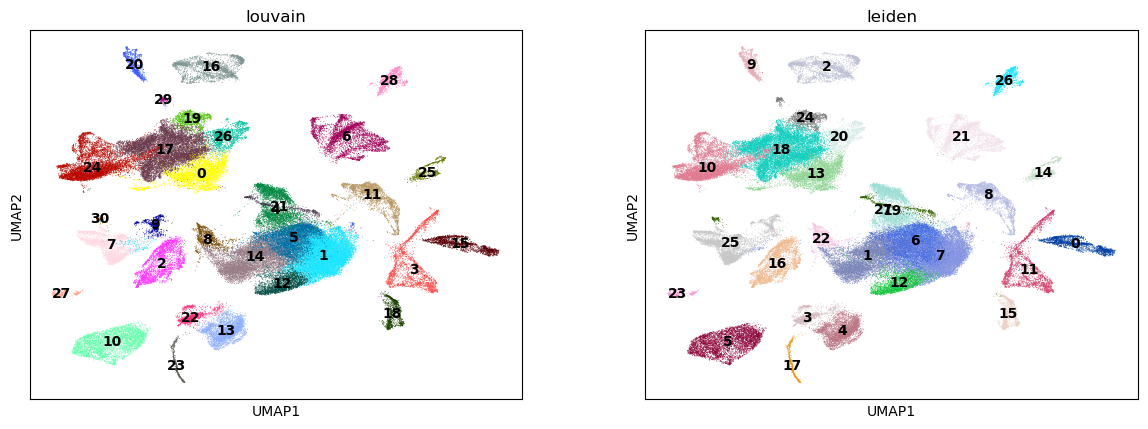

CPU times: user 687 ms, sys: 121 ms, total: 808 ms
Wall time: 649 ms


In [38]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

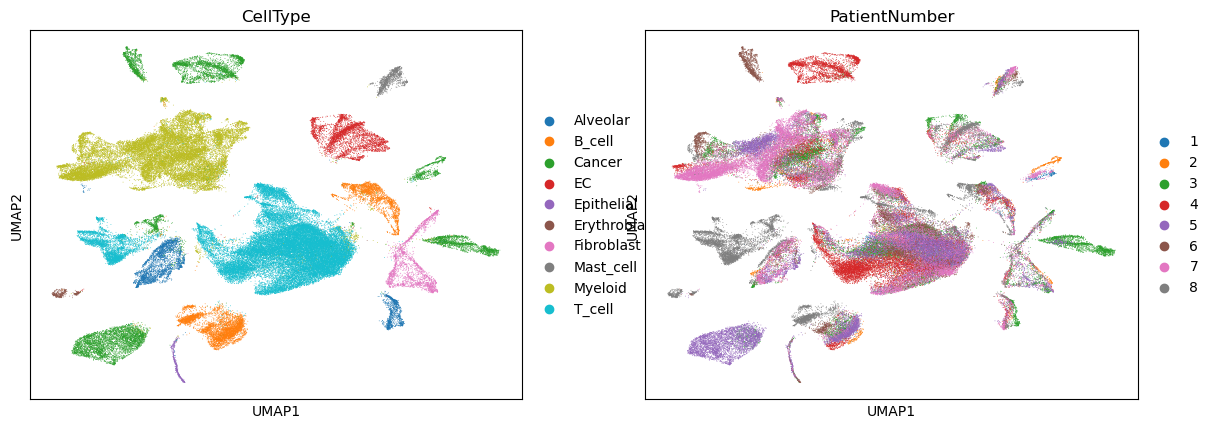

In [39]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

We also caluclate the embedding density in the UMAP using cuML

In [40]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 763 ms, sys: 48.9 ms, total: 812 ms
Wall time: 811 ms


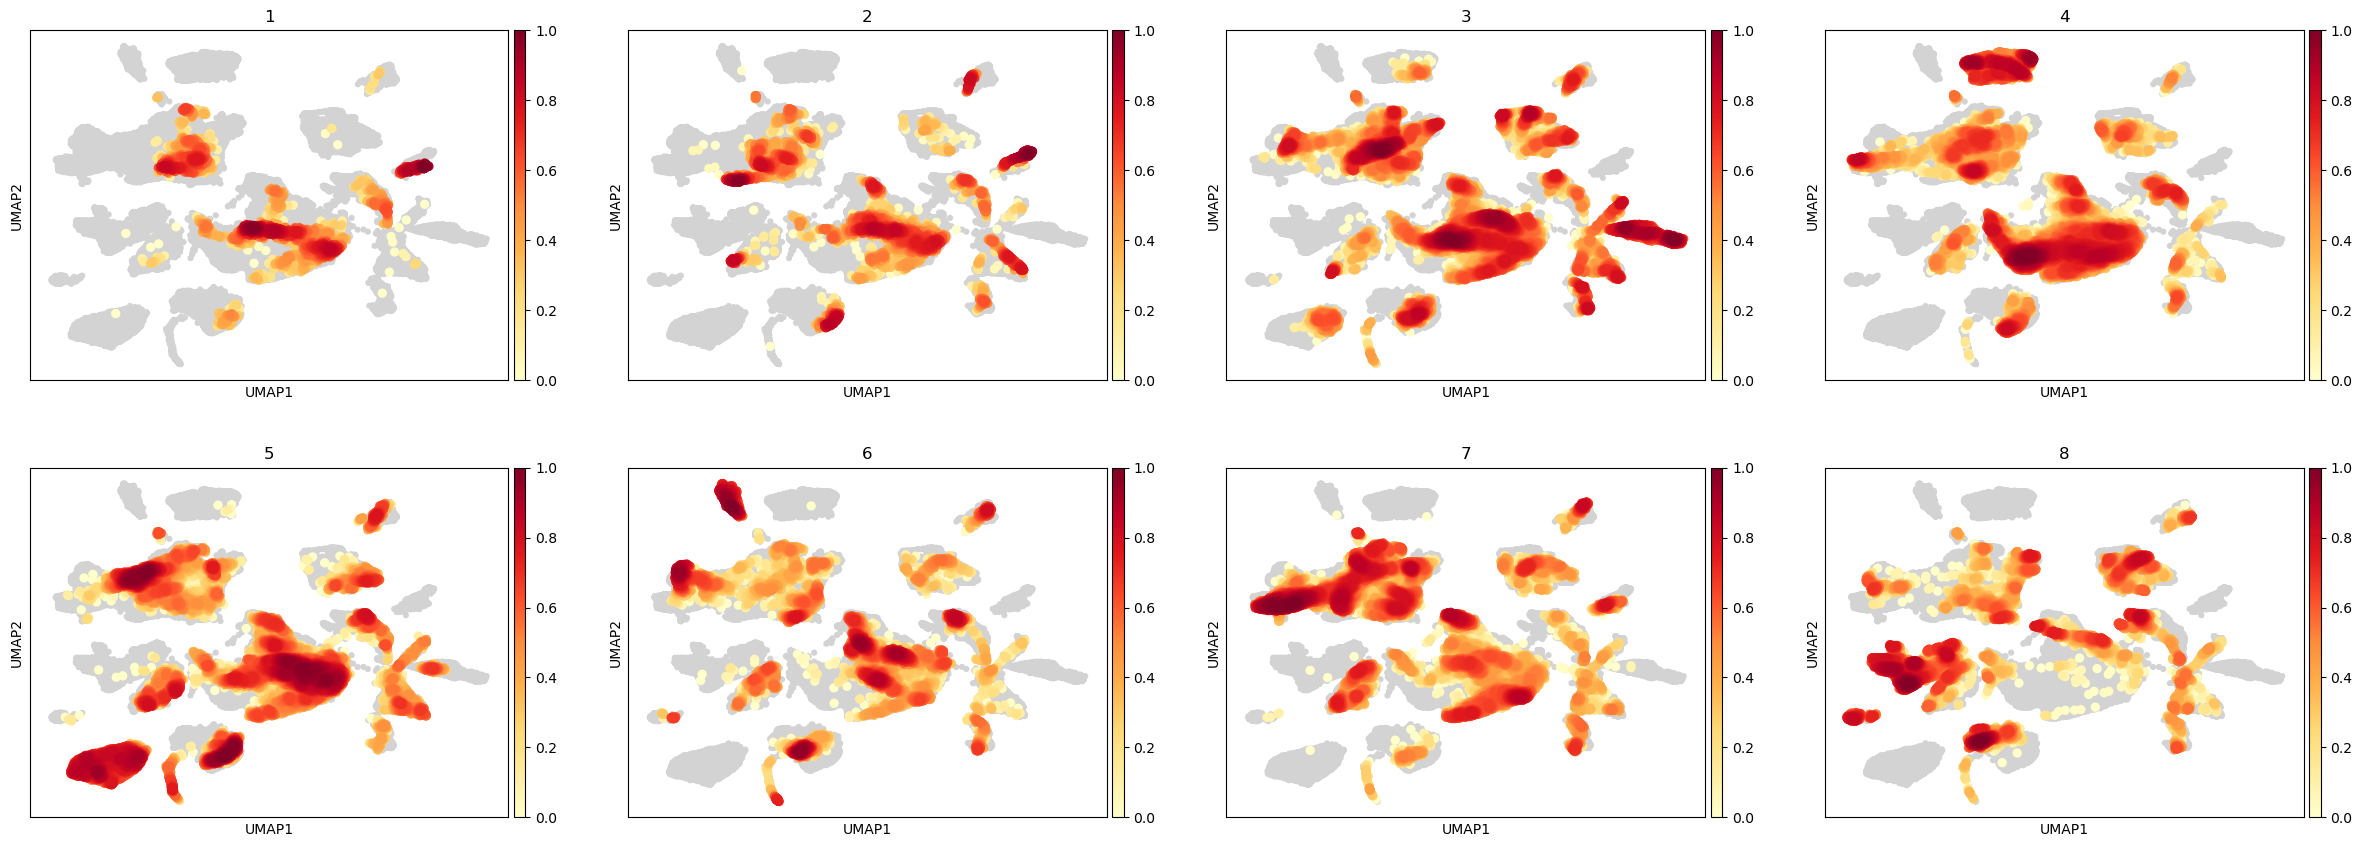

In [41]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [42]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

[W] [20:46:23.485986] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 971 ms, sys: 726 ms, total: 1.7 s
Wall time: 1.69 s


In [43]:
rsc.tl.kmeans(adata, n_clusters=8)

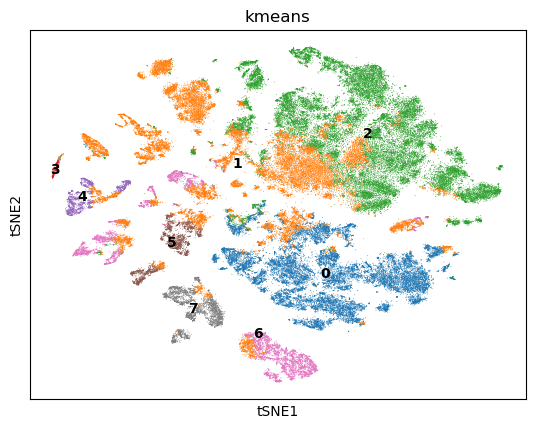

CPU times: user 298 ms, sys: 126 ms, total: 424 ms
Wall time: 265 ms


In [44]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

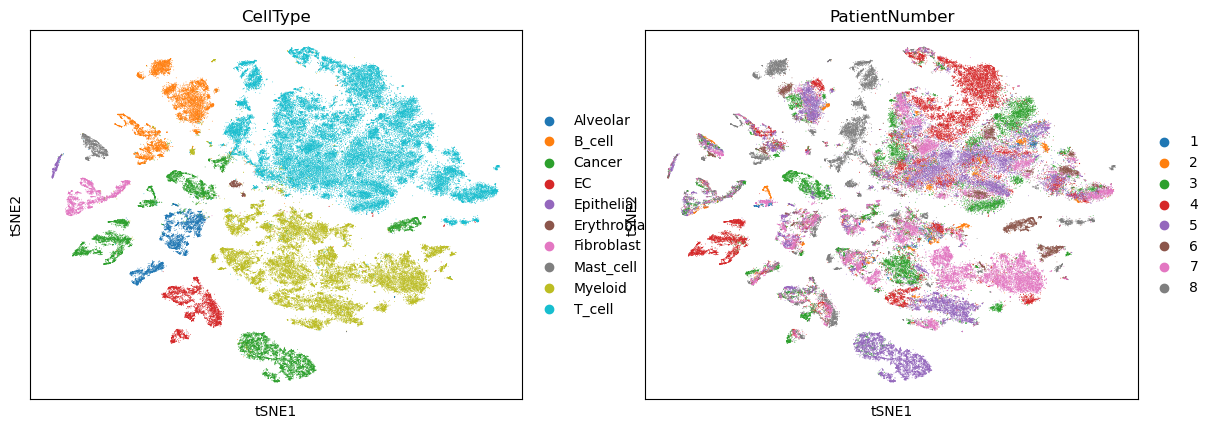

In [45]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [46]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.4 s, sys: 829 ms, total: 3.23 s
Wall time: 3.22 s


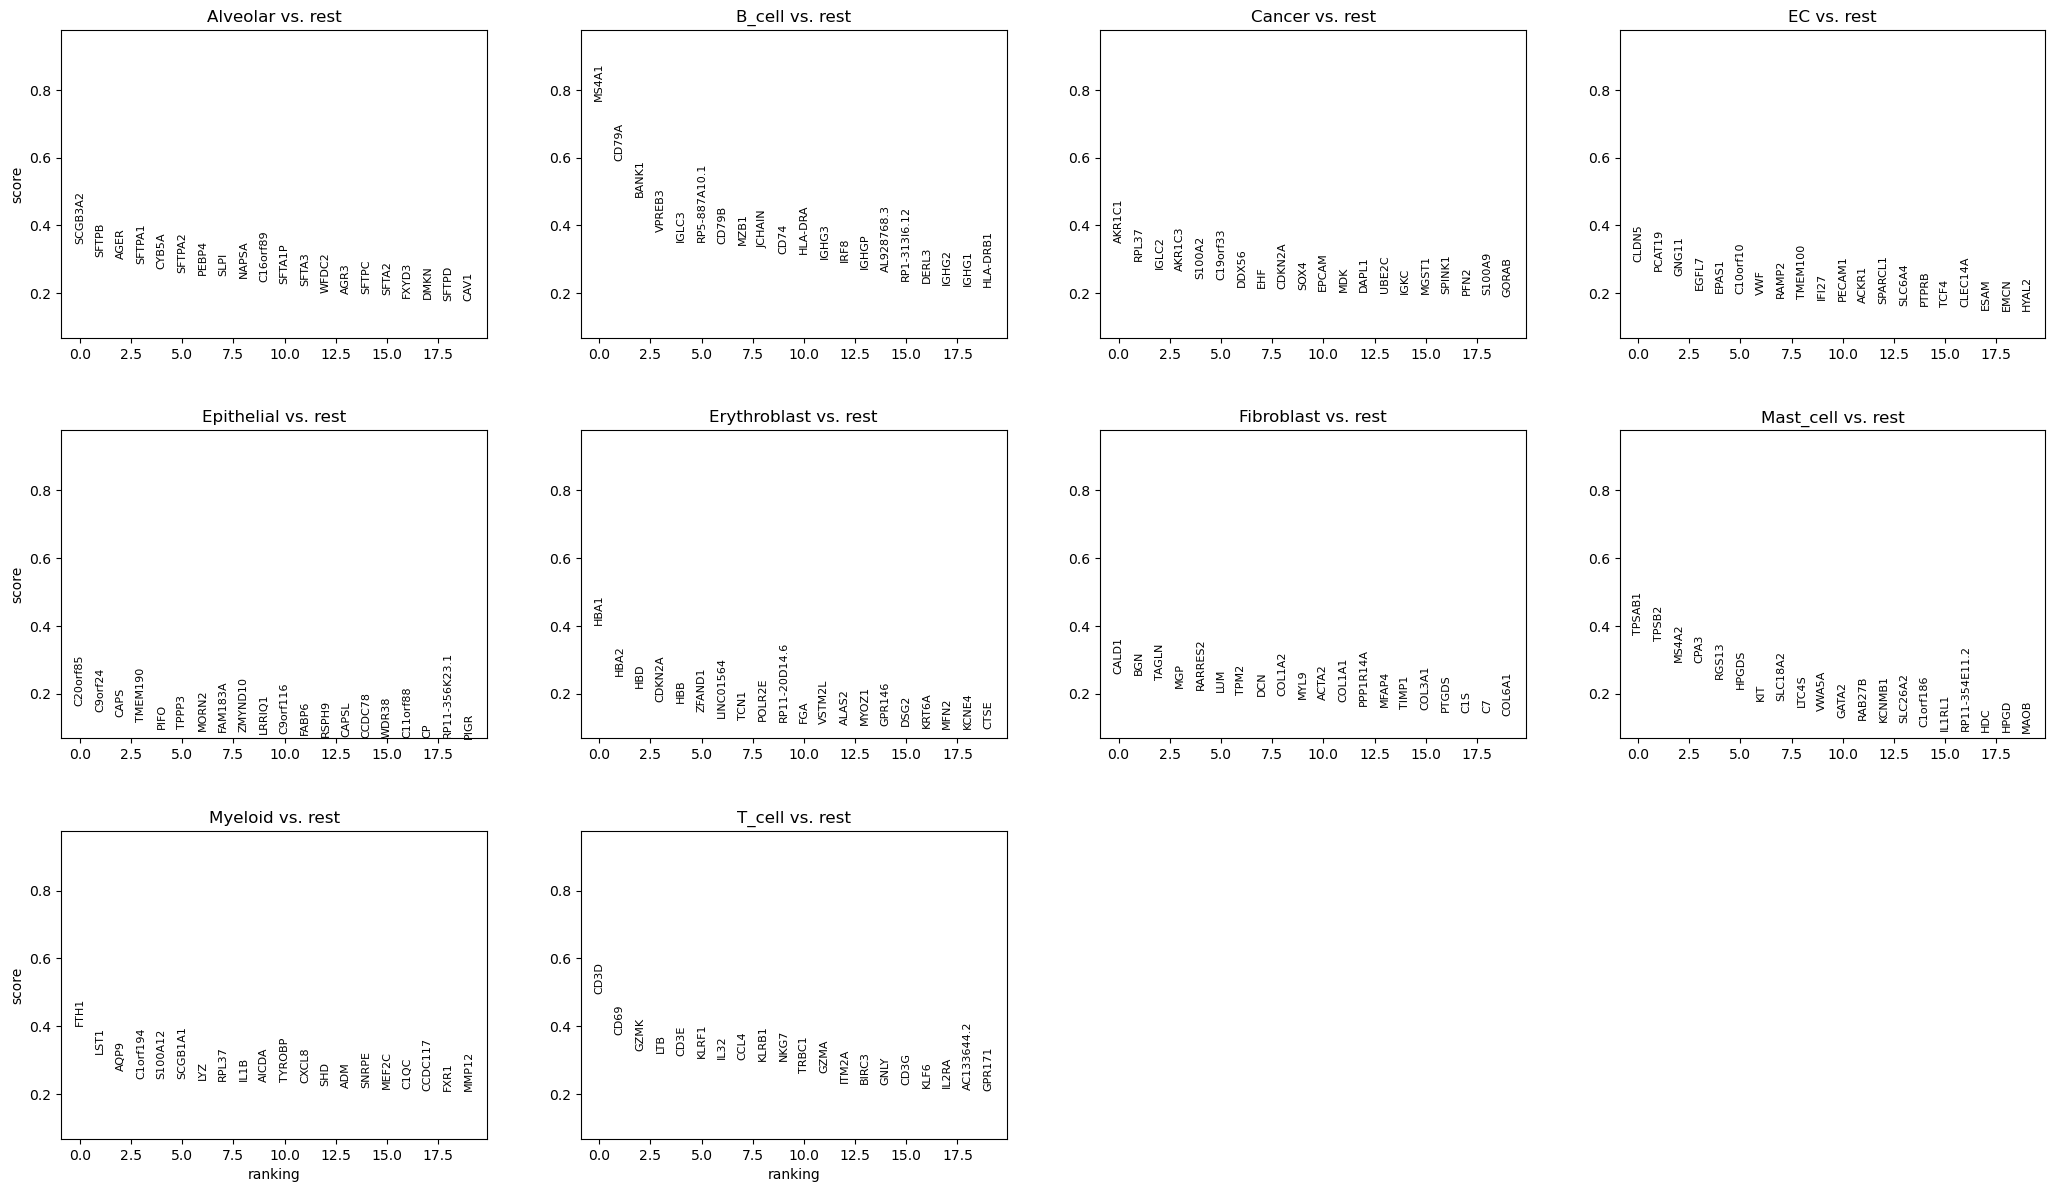

CPU times: user 996 ms, sys: 138 ms, total: 1.13 s
Wall time: 971 ms


In [47]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [48]:
post_time = time.time()

In [49]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 41.55280327796936


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [50]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

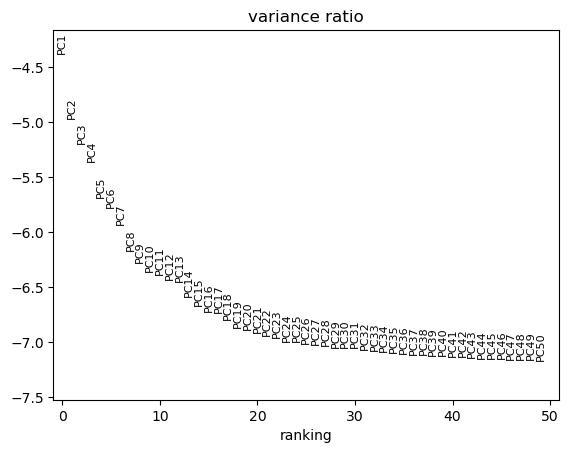

CPU times: user 869 ms, sys: 400 ms, total: 1.27 s
Wall time: 1.11 s


In [51]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [52]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20, method='rapids')
sc.tl.umap(tdata, method='rapids')
rsc.tl.leiden(tdata)

CPU times: user 697 ms, sys: 23.1 ms, total: 720 ms
Wall time: 711 ms


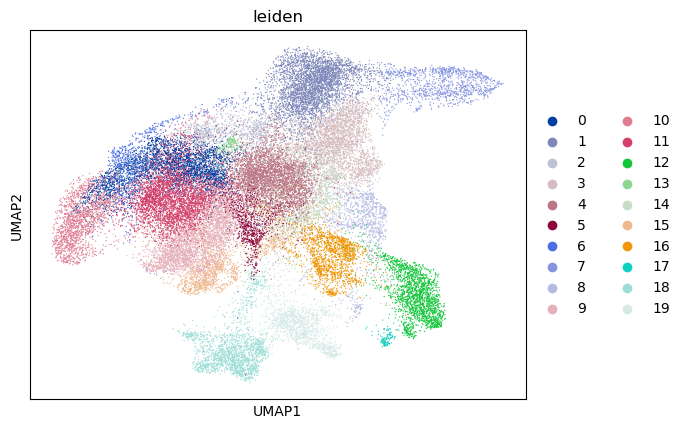

In [53]:
sc.pl.umap(tdata, color=["leiden"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [54]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 454 ms, sys: 1.06 s, total: 1.52 s
Wall time: 157 ms


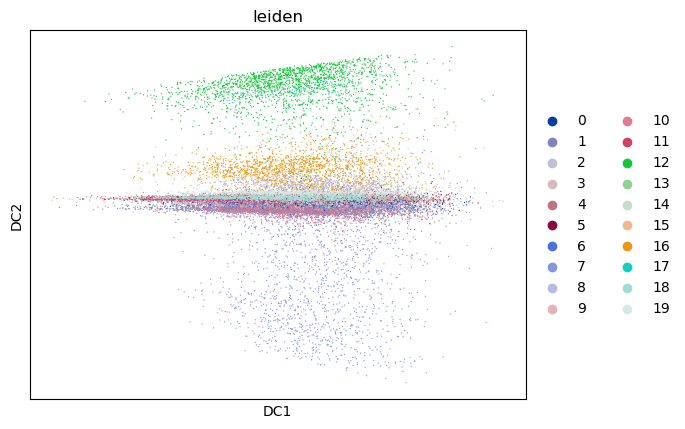

In [55]:
sc.pl.diffmap(tdata, color='leiden')

In [56]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 302 ms, sys: 757 µs, total: 302 ms
Wall time: 302 ms


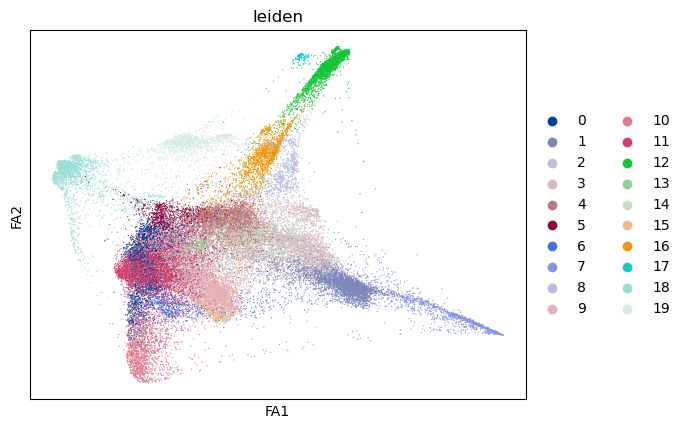

In [57]:
sc.pl.draw_graph(tdata, color='leiden')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [58]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 51.158695697784424
